In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier

In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Model
## Words, Train and Test

Repartition data

In [10]:
df_train, df_test = train_test_split(adm_notes, test_size=0.1)

Subsample non-readmitted patients to match size of readmitted ones

In [11]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)




Sparse Matrix with word count

In [12]:
# Tokenize and stem function
def tokenize_stem(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Assuming df_train and df_test are already defined and contain the required columns

# Vectorization
vect = CountVectorizer(lowercase=True, max_features=1000, tokenizer=tokenize_stem, token_pattern=None)

# Fit the vectorizer
vect.fit(df_train['TEXT'].values)

# Transform the text data
X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)

# Extract target variables
y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']


## Support Vector Machine

In [13]:
grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 2]
}

model_svm = GridSearchCV(SVC(), param_grid=grid, cv=3, n_jobs=-1)

In [14]:
model_svm.fit(X_train_tf, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 2], 'kernel': ['linear', 'poly', 'rbf']})

In [15]:
model_svm.best_params_

{'C': 2, 'kernel': 'rbf'}

In [16]:
y_train_preds = model_svm.predict(X_train_tf)
y_test_preds = model_svm.predict(X_test_tf)

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [18]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7536530535781192 0.6454304297798383
Accuracy	 0.7536530535781192 0.6979924994484888
Precission	 0.8030438675022381 0.12121212121212122
Recall		 0.6721618583739228 0.5850340136054422


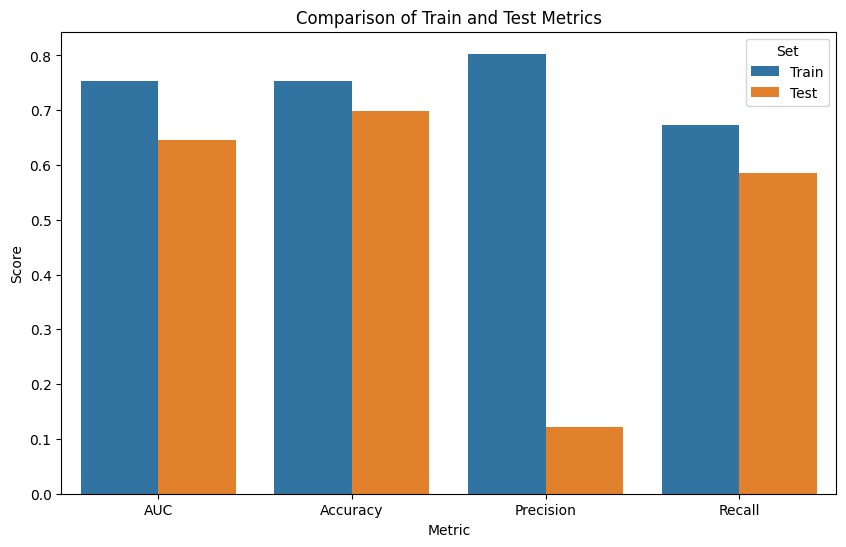

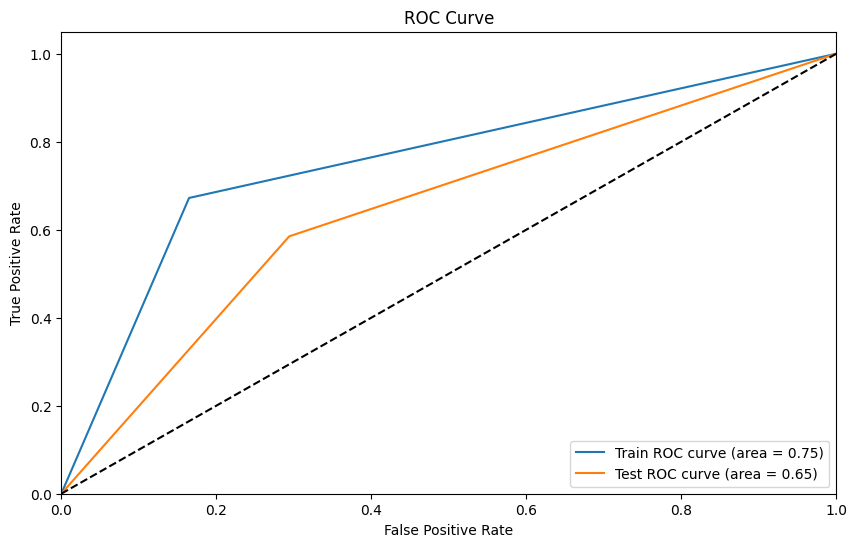

In [19]:
# Calculate ROC curves and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_preds)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Calculate other metrics
acc_train = accuracy_score(y_train, y_train_preds)
acc_test = accuracy_score(y_test, y_test_preds)

prec_train = precision_score(y_train, y_train_preds)
prec_test = precision_score(y_test, y_test_preds)

rec_train = recall_score(y_train, y_train_preds)
rec_test = recall_score(y_test, y_test_preds)

# Create a bar plot to compare metrics
metrics_dict = {
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall'],
    'Train': [auc_train, acc_train, prec_train, rec_train],
    'Test': [auc_test, acc_test, prec_test, rec_test]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_df_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Set', data=metrics_df_melted)
plt.title('Comparison of Train and Test Metrics')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Multi-layer Perceptron

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Define the parameter grid
grid = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate_init': [0.01, 0.001, 0.0001]
}

# Initialize the GridSearchCV with the MLPClassifier
model_mlp = GridSearchCV(MLPClassifier(hidden_layer_sizes=(10, 2), max_iter=6000), param_grid=grid, cv=5)

# Fit the model to the training data
model_mlp.fit(X_train_tf, y_train)

# Access the best parameters found by the grid search
best_params = model_mlp.best_params_
print(best_params)


{'alpha': 0.01, 'learning_rate_init': 0.001, 'solver': 'sgd'}


In [21]:
y_train_preds = model_mlp.predict(X_train_tf)
y_test_preds = model_mlp.predict(X_test_tf)

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [23]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.5 0.5
Accuracy	 0.5 0.06485771012574454
Precission	 0.5 0.06485771012574454
Recall		 1.0 1.0


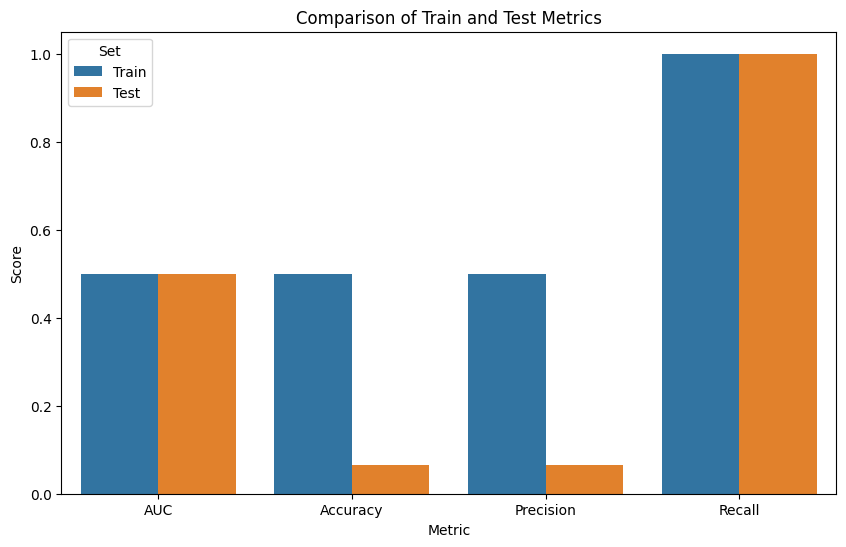

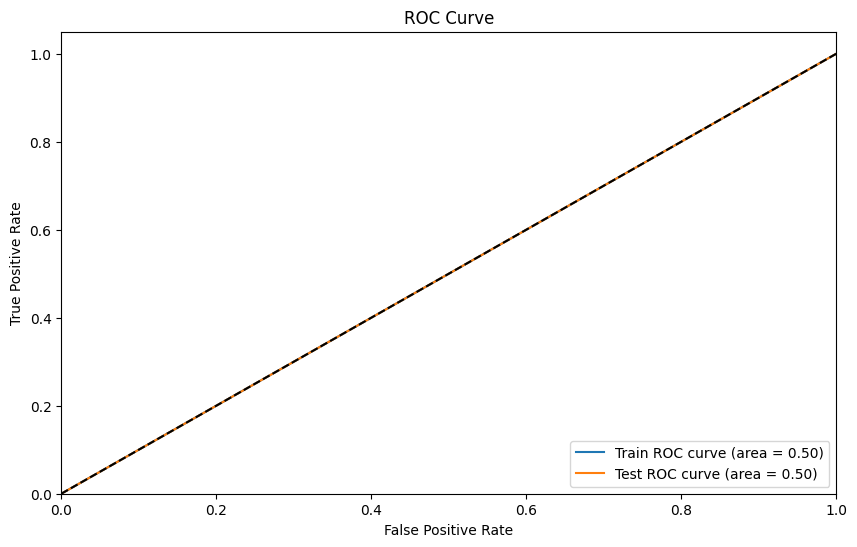

In [24]:
# Calculate ROC curves and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_preds)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Calculate other metrics
acc_train = accuracy_score(y_train, y_train_preds)
acc_test = accuracy_score(y_test, y_test_preds)

prec_train = precision_score(y_train, y_train_preds)
prec_test = precision_score(y_test, y_test_preds)

rec_train = recall_score(y_train, y_train_preds)
rec_test = recall_score(y_test, y_test_preds)

# Create a bar plot to compare metrics
metrics_dict = {
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall'],
    'Train': [auc_train, acc_train, prec_train, rec_train],
    'Test': [auc_test, acc_test, prec_test, rec_test]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_df_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Set', data=metrics_df_melted)
plt.title('Comparison of Train and Test Metrics')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_distributions = {
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 200, 300]
}

# Initialize the RandomizedSearchCV with the RandomForestClassifier
model_rf = RandomizedSearchCV(
    RandomForestClassifier(bootstrap=False), 
    param_distributions=param_distributions, 
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,  # Cross-validation splitting strategy
    random_state=42, 
    n_jobs=-1  # Use all available cores
)

# Fit the model to the training data
model_rf.fit(X_train_tf, y_train)

# Access the best parameters found by the random search
best_params = model_rf.best_params_
print(best_params)

# Make predictions
y_train_preds = model_rf.predict(X_train_tf)
y_test_preds = model_rf.predict(X_test_tf)


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40}


In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [27]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.9904458598726115 0.6471359244334677
Accuracy	 0.9904458598726115 0.6271784690050739
Precission	 1.0 0.1100558659217877
Recall		 0.9808917197452229 0.6700680272108843


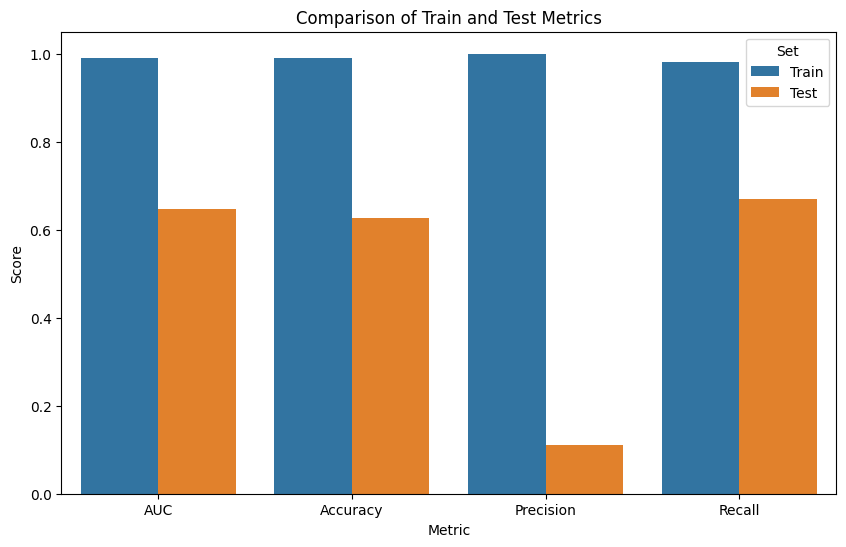

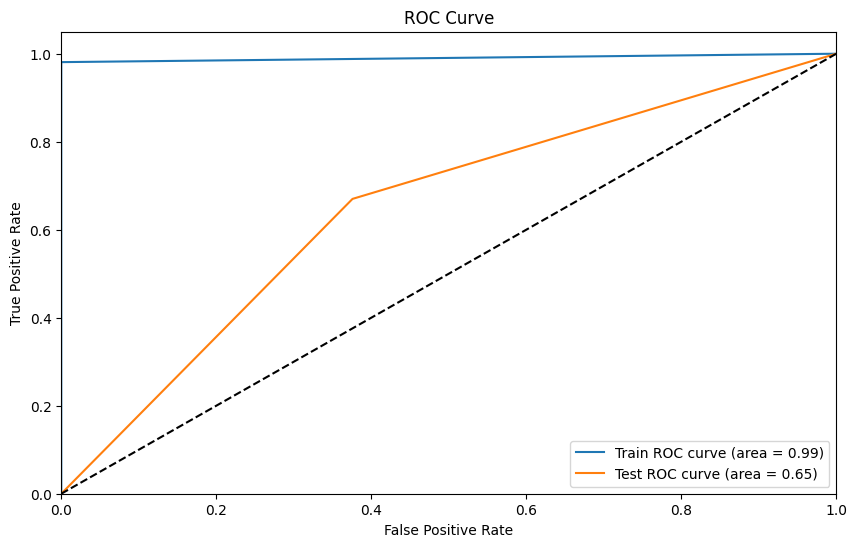

In [28]:
# Calculate ROC curves and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_preds)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Calculate other metrics
acc_train = accuracy_score(y_train, y_train_preds)
acc_test = accuracy_score(y_test, y_test_preds)

prec_train = precision_score(y_train, y_train_preds)
prec_test = precision_score(y_test, y_test_preds)

rec_train = recall_score(y_train, y_train_preds)
rec_test = recall_score(y_test, y_test_preds)

# Create a bar plot to compare metrics
metrics_dict = {
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall'],
    'Train': [auc_train, acc_train, prec_train, rec_train],
    'Test': [auc_test, acc_test, prec_test, rec_test]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_df_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Set', data=metrics_df_melted)
plt.title('Comparison of Train and Test Metrics')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Naive Bayes

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid
param_grid = {'alpha': [10, 1, 0.1, 0.01, 0.001]}

# Initialize the GridSearchCV with the MultinomialNB
model_nb = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the model to the training data
model_nb.fit(X_train_tf, y_train)


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [10, 1, 0.1, 0.01, 0.001]})

In [30]:
model_nb.best_params_

{'alpha': 1}

In [31]:
y_train_preds = model_nb.predict(X_train_tf)
y_test_preds = model_nb.predict(X_test_tf)

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_preds)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [33]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.6257025103034844 0.6264100119878098
Accuracy	 0.6257025103034844 0.671299360247077
Precission	 0.6402005850396991 0.11016949152542373
Recall		 0.5739977519670288 0.5748299319727891


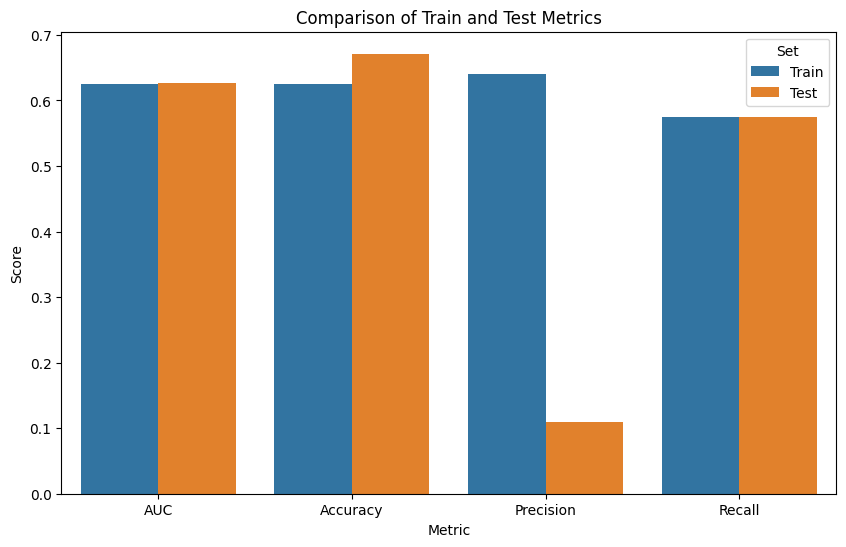

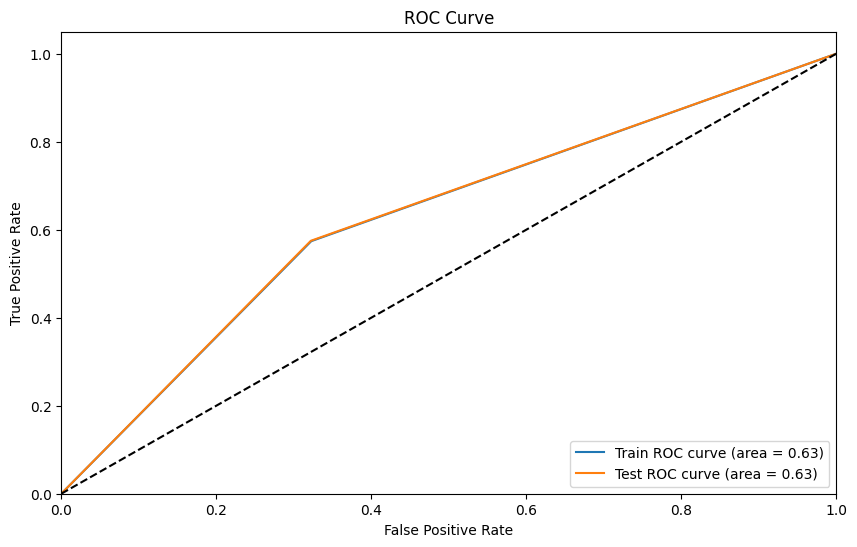

In [34]:

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB



# Calculate ROC curves and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_preds)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Calculate other metrics
acc_train = accuracy_score(y_train, y_train_preds)
acc_test = accuracy_score(y_test, y_test_preds)

prec_train = precision_score(y_train, y_train_preds)
prec_test = precision_score(y_test, y_test_preds)

rec_train = recall_score(y_train, y_train_preds)
rec_test = recall_score(y_test, y_test_preds)

# Create a bar plot to compare metrics
metrics_dict = {
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall'],
    'Train': [auc_train, acc_train, prec_train, rec_train],
    'Test': [auc_test, acc_test, prec_test, rec_test]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_df_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Set', data=metrics_df_melted)
plt.title('Comparison of Train and Test Metrics')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


There is no improvement when using the whole Dataset with ComplementNB, same scores on test

## XGBoost

In [38]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score

params = {
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1,1.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'max_depth': [4, 5],
    'eta': [0.01, 0.001]
}

# Initialize the GridSearchCV with the XGBClassifier
model_xgb = GridSearchCV(XGBClassifier(), param_grid=params, cv=5, n_jobs=-1)

# Fit the model to the training data
model_xgb.fit(X_train_tf, y_train)

# Access the best parameters found by the grid search
best_params = model_xgb.best_params_
print(best_params)

{'colsample_bytree': 1.0, 'eta': 0.01, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}


In [39]:
# Make predictions
y_train_preds = model_xgb.predict(X_train_tf)
y_test_preds = model_xgb.predict(X_test_tf)

In [40]:

# Calculate ROC curves and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_preds)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Calculate other metrics
acc_train = accuracy_score(y_train, y_train_preds)
acc_test = accuracy_score(y_test, y_test_preds)

prec_train = precision_score(y_train, y_train_preds)
prec_test = precision_score(y_test, y_test_preds)

rec_train = recall_score(y_train, y_train_preds)
rec_test = recall_score(y_test, y_test_preds)

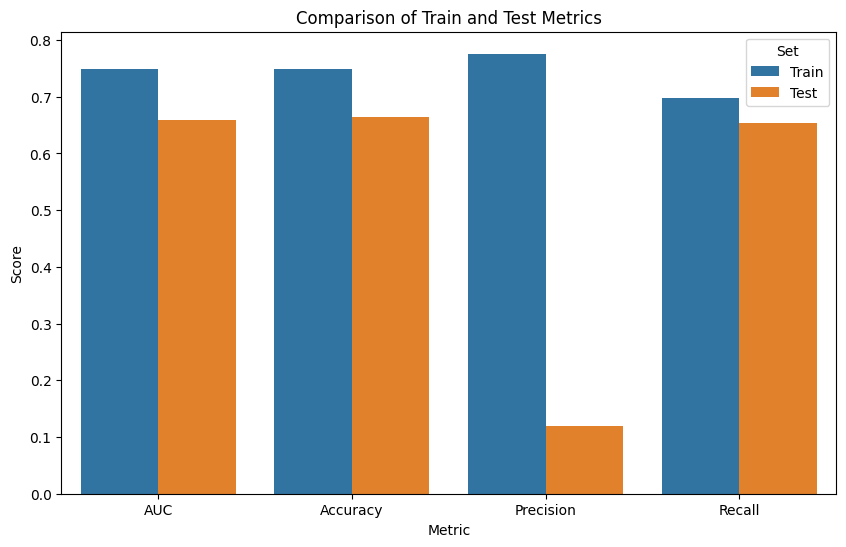

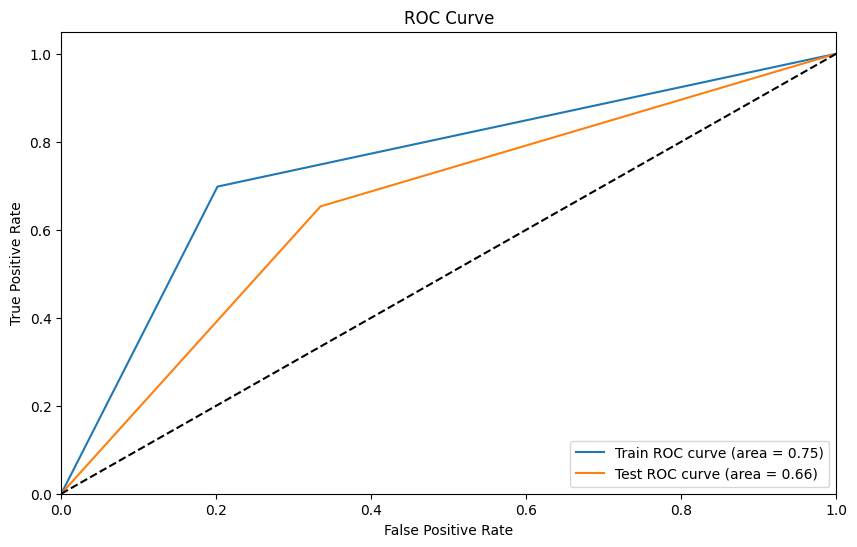

In [41]:


# Create a bar plot to compare metrics
metrics_dict = {
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall'],
    'Train': [auc_train, acc_train, prec_train, rec_train],
    'Test': [auc_test, acc_test, prec_test, rec_test]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Set', data=metrics_df_melted)
plt.title('Comparison of Train and Test Metrics')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [42]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7482203072311726 0.6592741838419727
Accuracy	 0.7482203072311727 0.6646812265607766
Precission	 0.775926697209496 0.11925465838509317
Recall		 0.6980142375421506 0.6530612244897959
